In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')



In [19]:
# Set Pandas display options 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [20]:
# Data Loading and Basic Exploration
def load_data():
    """Load training and test datasets"""
    train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
    test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
    return train, test

def basic_eda(df):
    """Perform basic exploratory data analysis"""
    print(f"Dataset Shape: {df.shape}")
    print("\nMissing Values:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    return df.describe()

In [21]:

# Plot all columns
def plot_all_columns(df):
    """Plot distributions for all columns in the dataset"""
    # Calculate number of rows needed (2 columns per row)
    n_cols = len(df.columns)
    n_rows = (n_cols + 1) // 2
    
    # Create figure
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
    axes = axes.ravel()  # Flatten axes array
    
    # Plot each column
    for idx, col in enumerate(df.columns):
        # For numeric columns
        if df[col].dtype in ['int64', 'float64']:
            # Distribution plot
            sns.histplot(data=df, x=col, ax=axes[idx], kde=True)
            axes[idx].set_title(f'Distribution of {col}')
        # For categorical columns
        else:
            # Bar plot
            value_counts = df[col].value_counts()
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[idx])
            axes[idx].set_title(f'Count of {col}')
            axes[idx].tick_params(axis='x', rotation=45)
    
    # Remove empty subplots if odd number of columns
    if n_cols % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()



In [22]:
def plot_correlation_matrix(df):
    """Plot correlation matrix for numerical features"""
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    sns.heatmap(corr_matrix, 
                cmap='coolwarm', 
                center=0,
                square=True, # Make cells square
                linewidths=0.5,
                cbar_kws={"shrink": .5})
    
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

In [23]:
# Data Preprocessing
def handle_missing_values(df):
    """Handle missing values in the dataset"""
    # Remove columns with more than 20% missing values
    missing_percentage = df.isnull().sum() / len(df) * 100
    columns_to_drop = missing_percentage[missing_percentage > 20].index
    df = df.drop(columns=columns_to_drop)
    
    # Handle remaining missing values
    # Numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    
    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df

In [24]:
def handle_outliers(df, columns, n_std=3):
    """Remove outliers using the z-score method"""
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = df[col].clip(mean - n_std * std, mean + n_std * std)
    return df

In [25]:
def feature_engineering(df):
    """Create new features"""
    # Total Square Footage
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # Total Bathrooms
    df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath']) + \
                          df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
    
    # Overall Quality Square
    df['OverallQual2'] = df['OverallQual'] ** 2
    
    # Age Features
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['Remod_Age'] = df['YrSold'] - df['YearRemodAdd']
    
    # Total Porch SF
    df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + \
                        df['3SsnPorch'] + df['ScreenPorch']
    
    return df

In [26]:
def prepare_features(df):
    """Prepare features for modeling"""
    # Convert categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    
    # Scale numerical features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return df_scaled

In [27]:

from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y):
    """Plot learning curves for a given model"""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    # Calculate mean and std deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
    
    # Plot the std deviation as a shaded area
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, 
                     val_scores_mean + val_scores_std, alpha=0.1, color='g')
    
    plt.title(f'Learning Curves for {model.__class__.__name__}')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [28]:

def train_and_evaluate_models(X_train, X_val, y_train, y_val):
    """Train and evaluate multiple models with hyperparameter tuning"""
    # Define parameter grids for each model
    param_grids = {
        'Linear Regression': {'fit_intercept': [True]},
        
        'Ridge': {
            'alpha': [0.1, 1.0, 10.0],
            'fit_intercept': [True, False]
        },
        
        'Lasso': {
            'alpha': [0.1, 1.0, 10.0],
            'fit_intercept': [True, False]
        },
        
        'ElasticNet': {
            'alpha': [0.1, 1.0, 10.0],
            'l1_ratio': [0.2, 0.5, 0.8],
            'fit_intercept': [True, False]
        },
        
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        
        'XGBoost': {
            'n_estimators': [500, 1000],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.7, 0.9],
            'colsample_bytree': [0.7, 0.9]
        },
        
    }

    base_models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'ElasticNet': ElasticNet(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42)
    }

    results = {}
    predictions = {}
    best_models = {}
    
    for name, model in base_models.items():
        print(f"\nTuning and training {name}...")
        
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        
        # Fit grid search
        grid_search.fit(X_train, y_train)
        
        # Get best model
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        
        # Plot learning curves for the best model
        plot_learning_curves(best_model, X_train, y_train)
        # Make predictions with best model
        train_pred = best_model.predict(X_train)
        val_pred = best_model.predict(X_val)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        train_r2_score = r2_score(y_train, train_pred)
        val_r2_score = r2_score(y_val, val_pred)
        
        # Model fit status
        
        results[name] = {
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'train_r2': train_r2_score,
            'val_r2': val_r2_score,
            'best_params': grid_search.best_params_,
        }
        predictions[name] = val_pred
        
        print(f'{name} - Best Parameters: {grid_search.best_params_}')
        print(f'{name} - Training RMSE: {train_rmse:.4f}')
        print(f'{name} - Validation RMSE: {val_rmse:.4f}')
        print(f'{name} - Training R2 Score: {train_r2_score:.4f}')
        print(f'{name} - Validation R2 Score: {val_r2_score:.4f}')
    
    return results, predictions, best_models

In [29]:
def plot_model_comparison(results):
    """Plot model comparison graphs"""
    # Prepare data for plotting
    models = list(results.keys())
    train_rmse = [results[m]['train_rmse'] for m in models]
    val_rmse = [results[m]['val_rmse'] for m in models]
    r2_scores = [results[m]['val_r2'] for m in models]

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Plot RMSE comparison
    x = np.arange(len(models))
    width = 0.35

    ax1.bar(x - width/2, train_rmse, width, label='Training RMSE')
    ax1.bar(x + width/2, val_rmse, width, label='Validation RMSE')
    ax1.set_ylabel('RMSE Score')
    ax1.set_title('Model Comparison - RMSE Scores')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45)
    ax1.legend()

    # Plot R2 scores
    ax2.bar(models, r2_scores)
    ax2.set_ylabel('R2 Score')
    ax2.set_title('Model Comparison - R2 Scores')
    ax2.set_xticklabels(models, rotation=45)

    plt.tight_layout()
    plt.show()

In [30]:
def plot_prediction_comparison(y_true, predictions):
    """Plot actual vs predicted values for each model"""
    n_models = len(predictions)
    fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, (name, pred) in enumerate(predictions.items()):
        axes[idx].scatter(y_true, pred, alpha=0.5)
        axes[idx].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        axes[idx].set_title(f'{name}\nActual vs Predicted')
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
    plt.tight_layout()
    plt.show()

In [31]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    print(f'RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    return predictions

# MAIN EXECUTION

In [32]:
# Main execution
def main():
    # Load data
    print("Loading data...")
    train_df, test_df = load_data()
    
    # Basic EDA
    print("\nPerforming basic EDA...")
    basic_eda(train_df)
    # Correlation matrix
    print("\nPlotting correlation matrix...")
    plot_correlation_matrix(train_df)
    # Plot all columns
    print("\nPlotting all columns...")
    plot_all_columns(train_df)
    
    # Separate target variable
    y = np.log1p(train_df['SalePrice'])
    X = train_df.drop(['SalePrice', 'Id'], axis=1)
    test_ids = test_df['Id']
    test_df = test_df.drop('Id', axis=1)
    
    # Combine train and test for preprocessing
    all_data = pd.concat([X, test_df], axis=0)
    
    # Preprocessing
    print("\nPreprocessing data...")
    all_data = handle_missing_values(all_data)
    all_data = feature_engineering(all_data)
    all_data = prepare_features(all_data)
    
    # Split back to train and test
    X = all_data[:len(X)]
    test_df = all_data[len(X):]
    
    # Split training data -> I can evaluate the model during training
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train and evaluate models
    print("\nTraining and evaluating models...")
    results, predictions, models = train_and_evaluate_models(X_train, X_val, y_train, y_val)
    
    # Plot model comparisons
    print("\nGenerating comparison plots...")
    plot_model_comparison(results)
    plot_prediction_comparison(y_val, predictions)
    
    # Select best model based on validation RMSE
    best_model_name = min(results, key=lambda x: results[x]['val_rmse'])
    best_model = models[best_model_name]
    print(f"\nBest performing model: {best_model_name}")
    
    # Make predictions on test set using best model
    print("\nMaking predictions with best model...")
    test_predictions = best_model.predict(test_df)
    test_predictions = np.expm1(test_predictions)
    
    # Create submission file
    submission = pd.DataFrame({
        'Id': test_ids,
        'SalePrice': test_predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("\nSubmission file created!")


Loading data...

Performing basic EDA...
Dataset Shape: (1460, 81)

Missing Values:
LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Plotting correlation matrix...


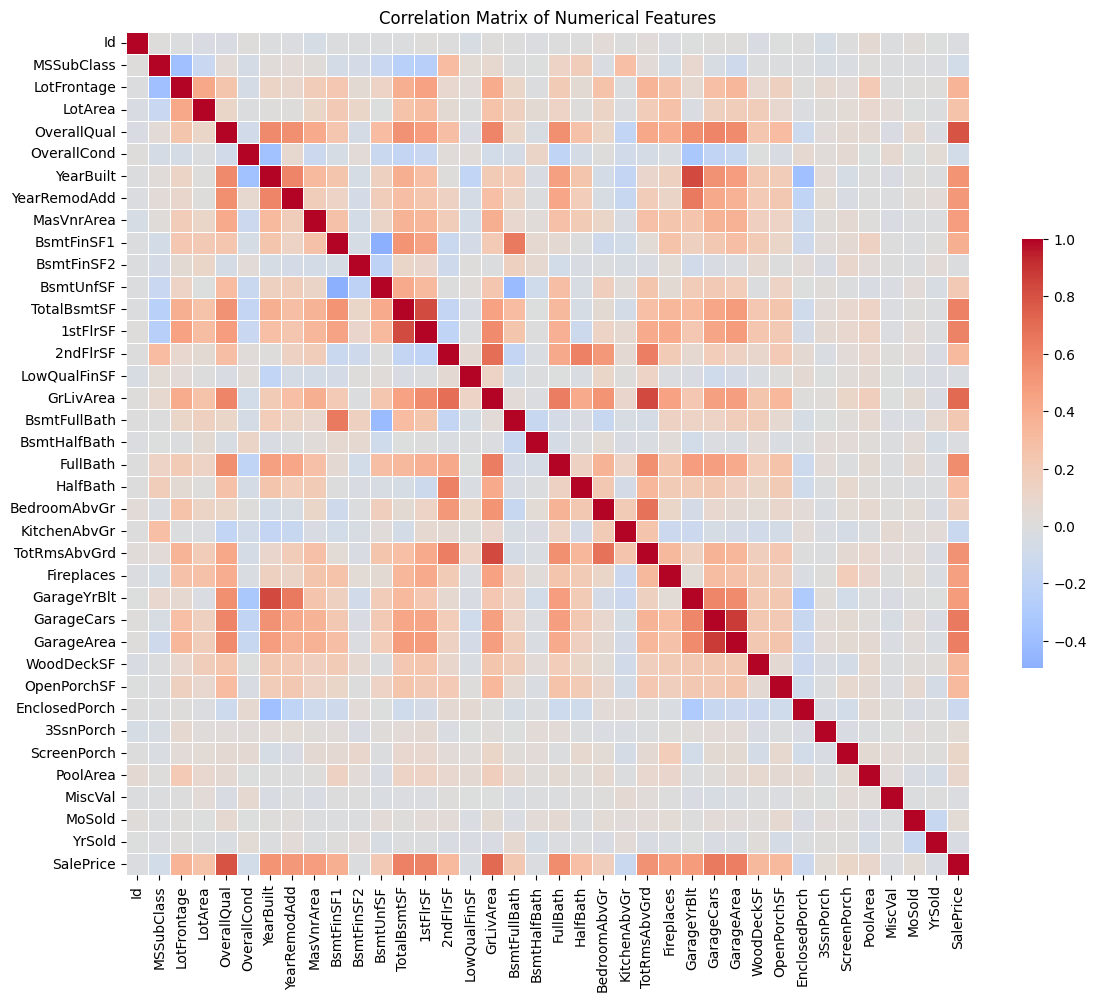


Plotting all columns...


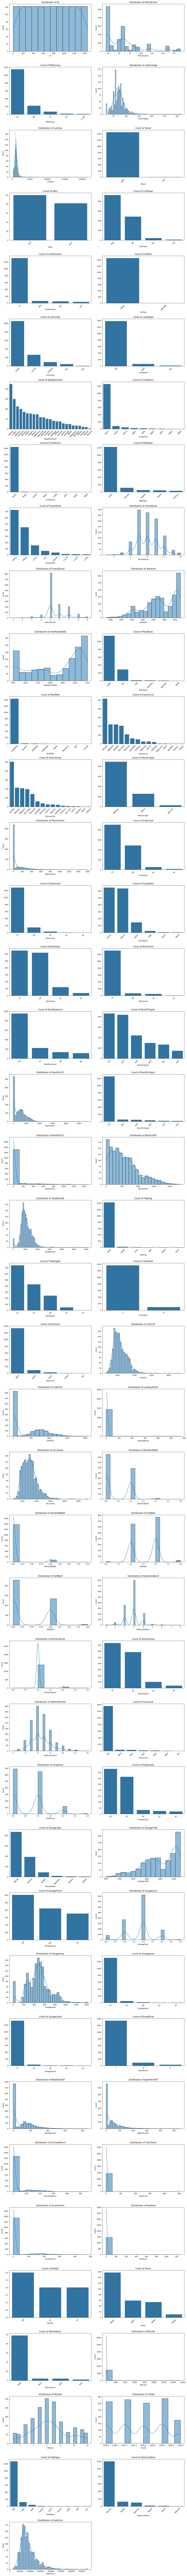


Preprocessing data...

Training and evaluating models...

Tuning and training Linear Regression...


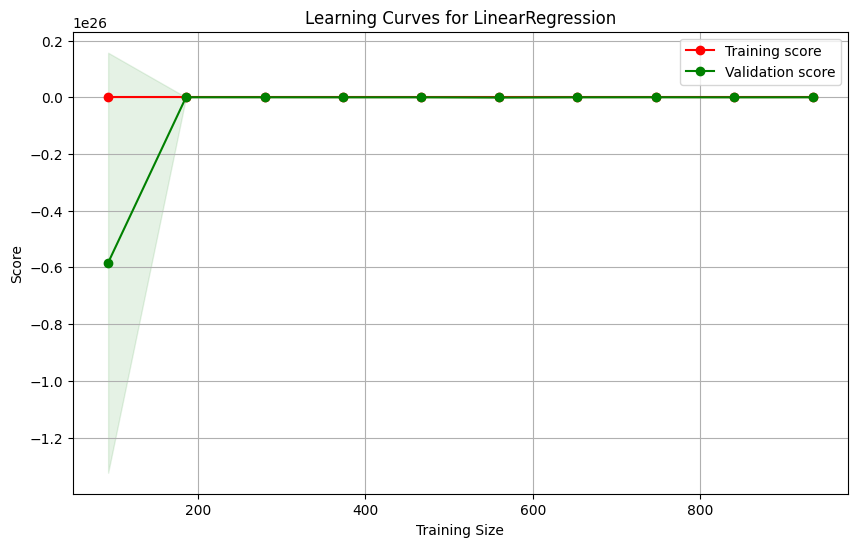

Linear Regression - Best Parameters: {'fit_intercept': True}
Linear Regression - Training RMSE: 0.1319
Linear Regression - Validation RMSE: 0.1532
Linear Regression - Training R2 Score: 0.8858
Linear Regression - Validation R2 Score: 0.8742

Tuning and training Ridge...


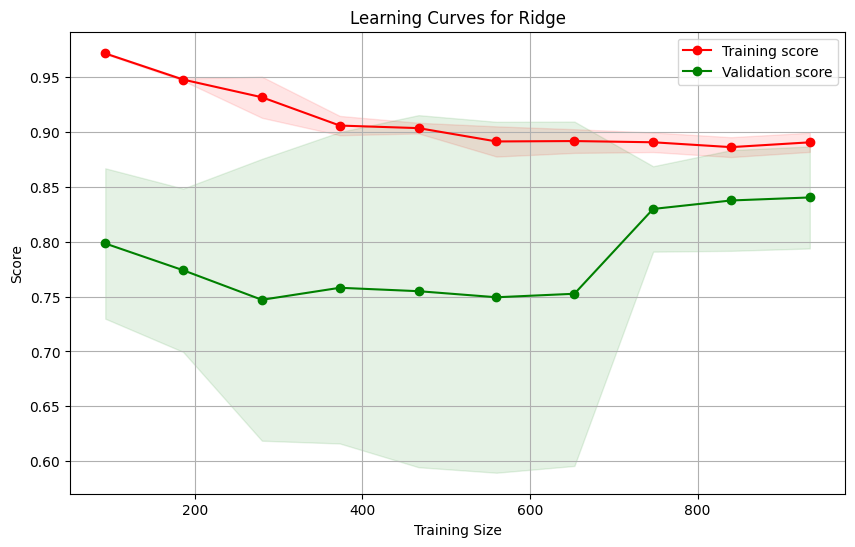

Ridge - Best Parameters: {'alpha': 10.0, 'fit_intercept': True}
Ridge - Training RMSE: 0.1321
Ridge - Validation RMSE: 0.1527
Ridge - Training R2 Score: 0.8856
Ridge - Validation R2 Score: 0.8750

Tuning and training Lasso...


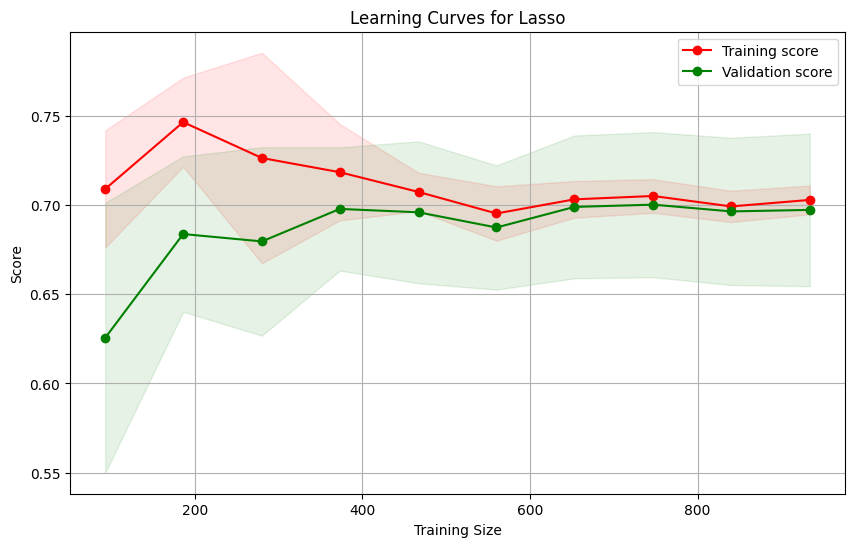

Lasso - Best Parameters: {'alpha': 0.1, 'fit_intercept': True}
Lasso - Training RMSE: 0.2134
Lasso - Validation RMSE: 0.2293
Lasso - Training R2 Score: 0.7012
Lasso - Validation R2 Score: 0.7182

Tuning and training ElasticNet...


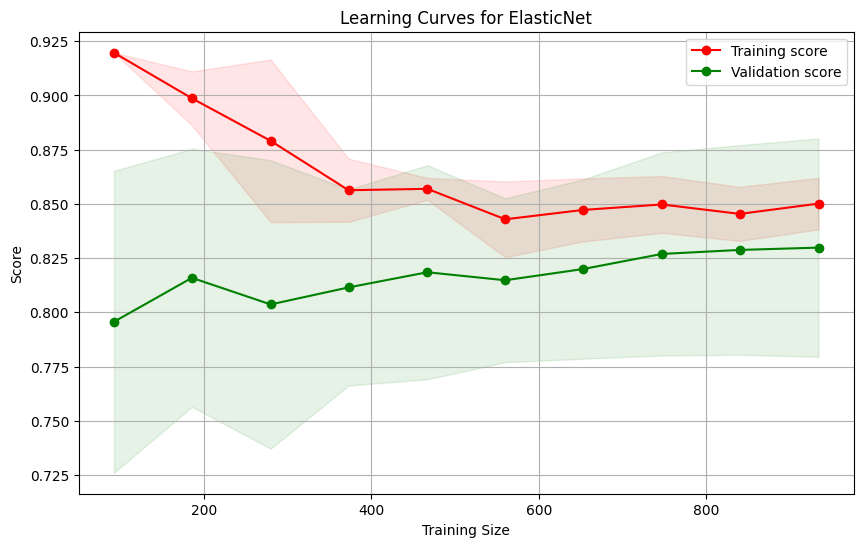

ElasticNet - Best Parameters: {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.2}
ElasticNet - Training RMSE: 0.1529
ElasticNet - Validation RMSE: 0.1629
ElasticNet - Training R2 Score: 0.8465
ElasticNet - Validation R2 Score: 0.8578

Tuning and training Random Forest...


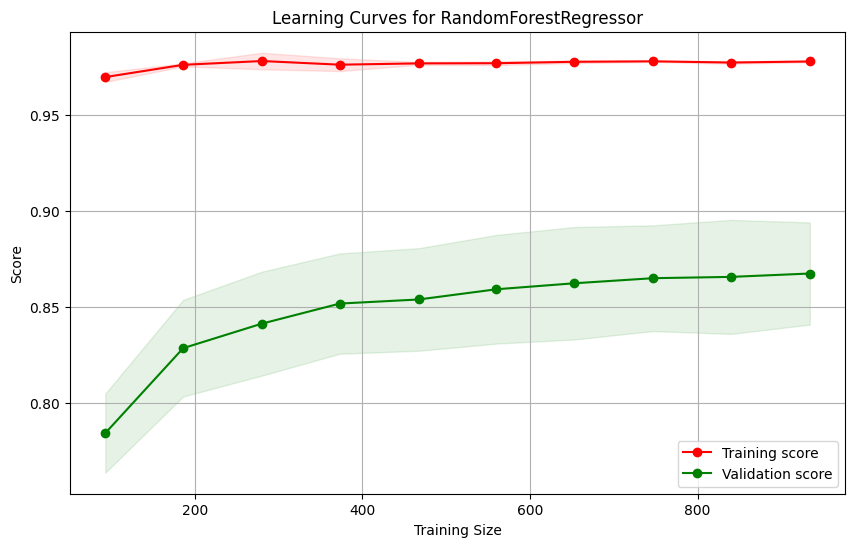

Random Forest - Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Training RMSE: 0.0579
Random Forest - Validation RMSE: 0.1443
Random Forest - Training R2 Score: 0.9780
Random Forest - Validation R2 Score: 0.8885

Tuning and training XGBoost...


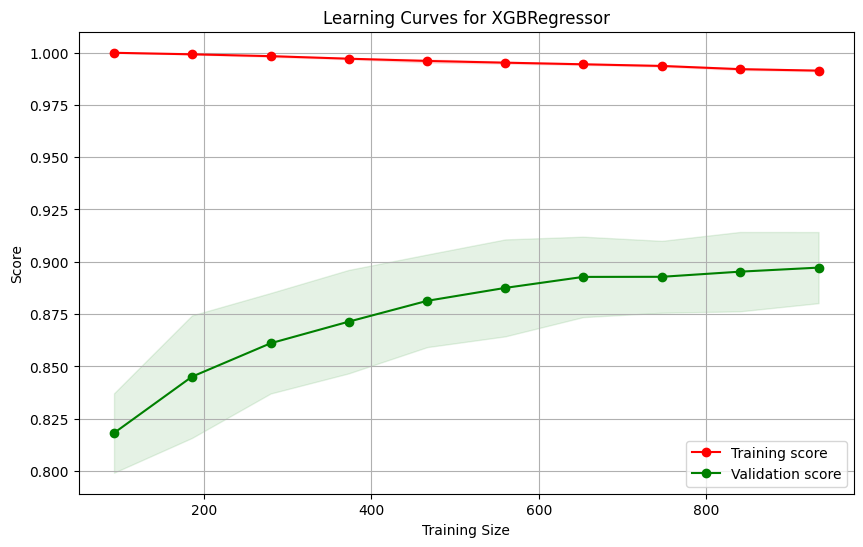

XGBoost - Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.7}
XGBoost - Training RMSE: 0.0417
XGBoost - Validation RMSE: 0.1314
XGBoost - Training R2 Score: 0.9886
XGBoost - Validation R2 Score: 0.9075

Generating comparison plots...


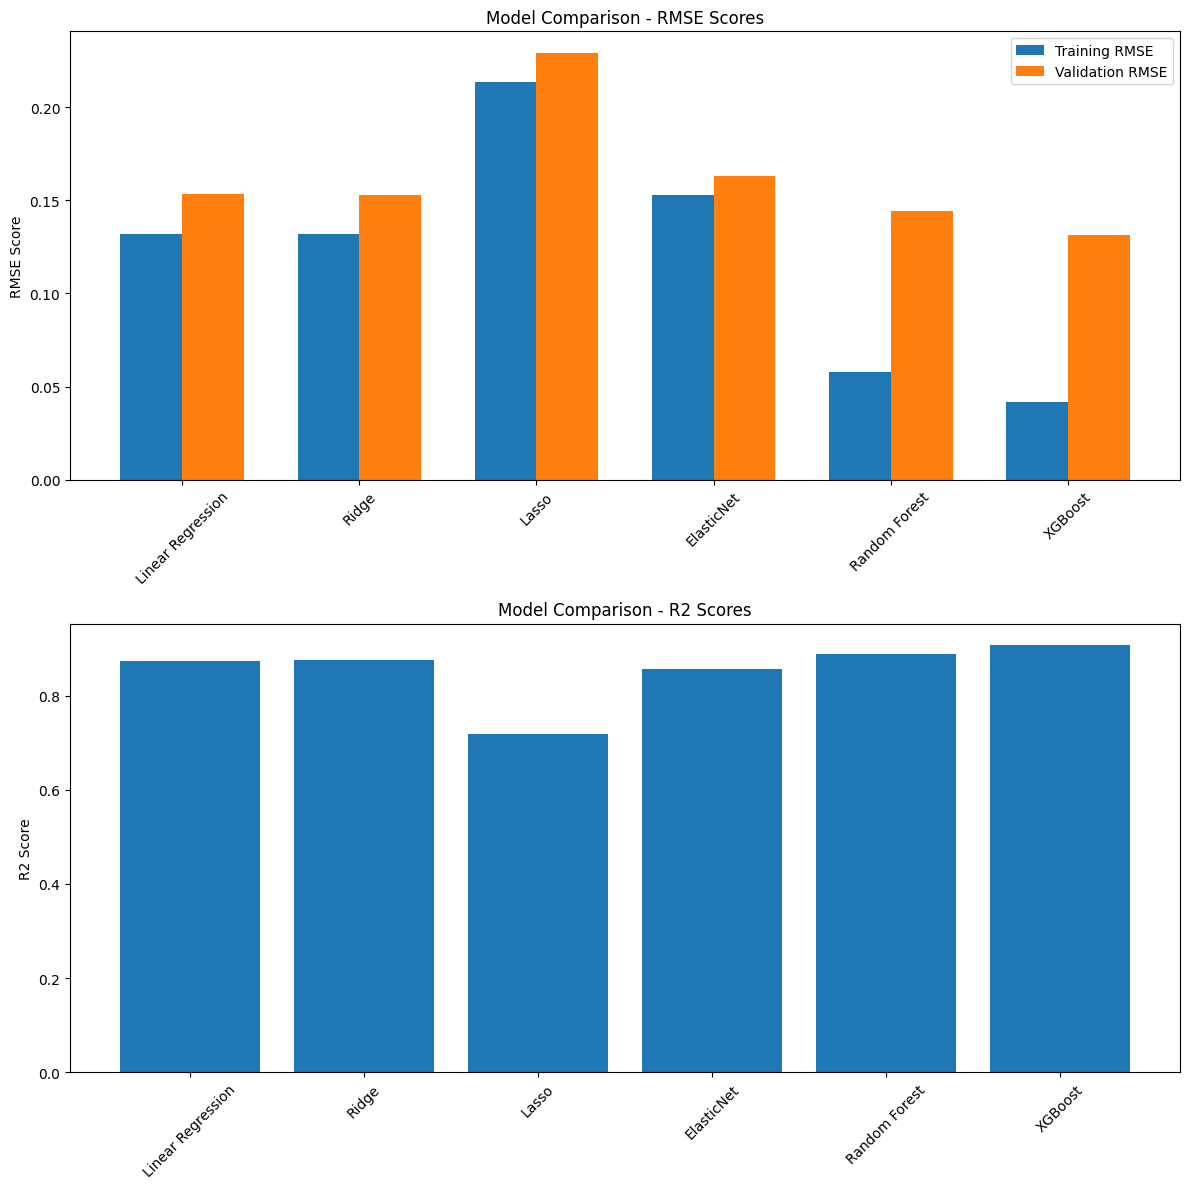

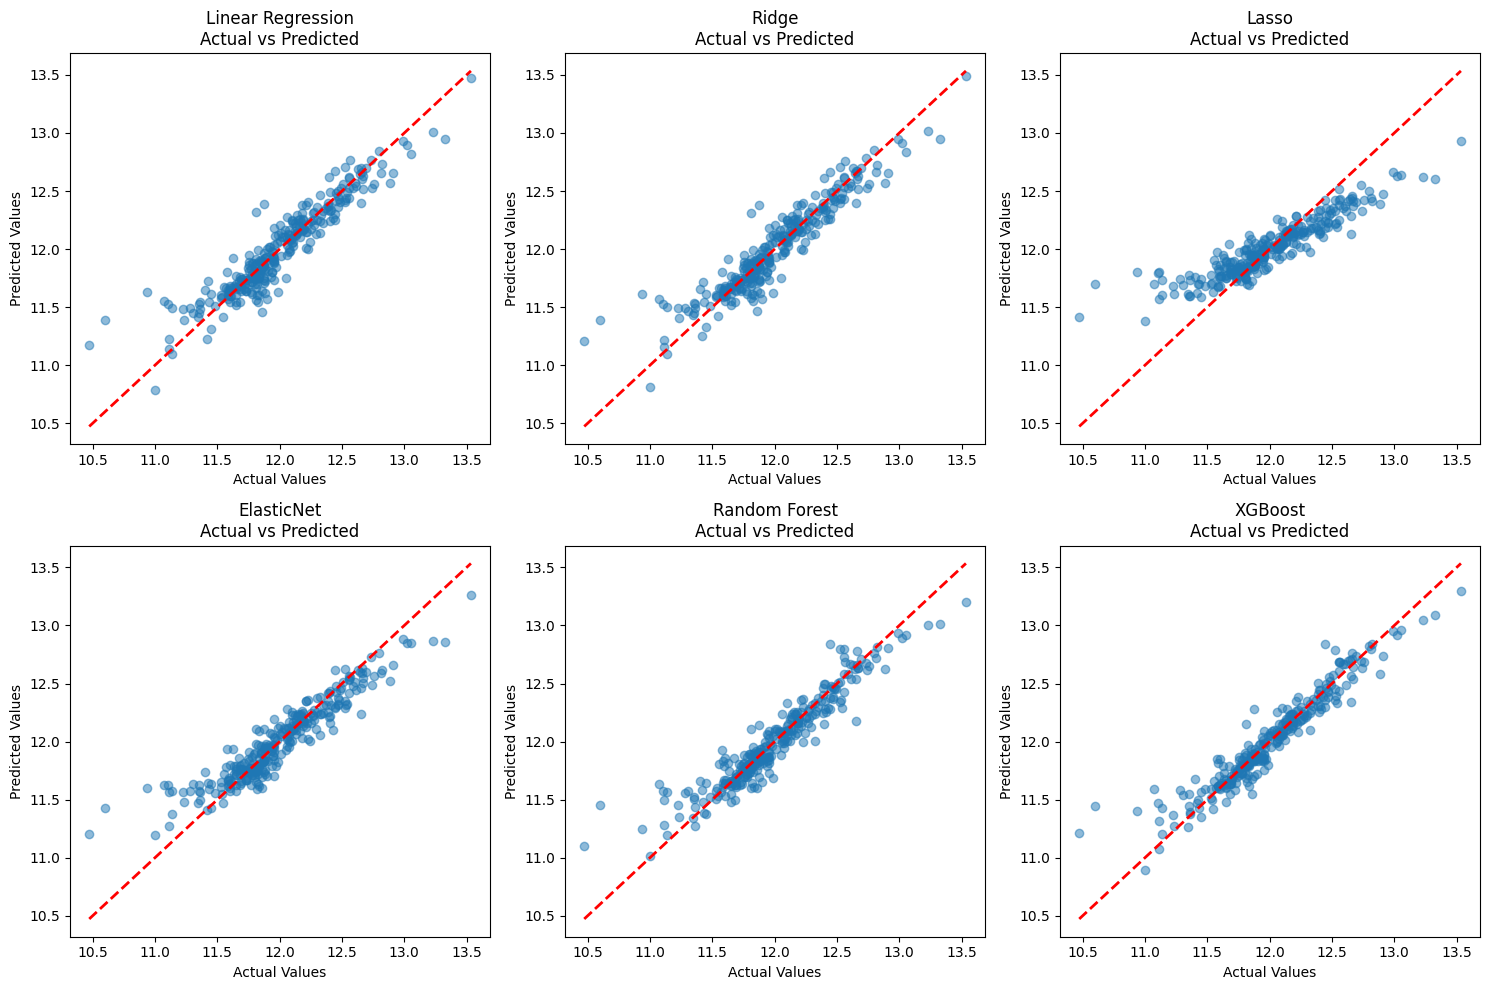


Best performing model: XGBoost

Making predictions with best model...

Submission file created!


In [33]:
if __name__ == "__main__":
    main()